In [199]:
##############################################
# Programmer: Matthew Moore
# Class: CptS 322-01, Spring 2022
# Programming Assignment #4
# 3/3/2022
# 
# 
# Description: This program runs through all of the visualizations for the assignment. The purpose of the file is
# to test the predictive accuracy of all of the classification methods we build in the myclassifiers.py class file. 
##############################################
import importlib
import os
import numpy as np

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
import mysklearn.myevaluation as myeval
import mysklearn.mysimplelinearregressor
from mysklearn.mysimplelinearregressor import MySimpleLinearRegressor
importlib.reload(mysklearn.myclassifiers)
importlib.reload(mysklearn.myevaluation)
from mysklearn.myclassifiers import MySimpleLinearRegressionClassifier,MyKNeighborsClassifier,\
    MyDummyClassifier, MyDecisionTreeClassifier, \
    MyNaiveBayesClassifier, MyRandomForestClassifier

# NCAA Basketball March Madness Tournament Predictor

#### By Matt Moore and Ben Higley

## Introduction


Team placement in the NCAA March Madness tournament is one of the most difficult outcomes to predict out of anything. Ben and I set out a mission to utilize our machine learning classifiers to get as close as possible to predicting the perfect bracket. We used a comprehensive data set from 2008-2022 of all March Madness team results as well as team statistics for that given season for from Barttovik.com, which we confirmed were accurate numbers. By training on this dataset, we were able to make relatively strong predictions (accuracy of 80%) on what round a given team would get to based on their seasonal statistics.

In [200]:
importlib.reload(np)
importlib.reload(os)
importlib.reload(mysklearn.myutils)
importlib.reload(mysklearn.mypytable)
importlib.reload(mysklearn.myclassifiers)
importlib.reload(mysklearn.myevaluation)
np.random.seed(0)

fname = os.path.join("input_data", "cbb.csv")
bball_table = MyPyTable()
bball_table.load_from_file(fname)

fname = os.path.join("input_data", "cbb2022.csv")
bball_table_test = MyPyTable()
bball_table_test.load_from_file(fname)
# stats_header = ['ADJOD','ADJDE','BARTHAG','EFG_O','EFG_D','TOR','TORD',\
    # 'ORB','DRB','FTR','FTRD','2P_O','2P_D','3P_O','3P_D','ADJ_T','WAB']

stats_header = ['ADJOE','ADJDE','BARTHAG','EFG_O','EFG_D','TOR','TORD',\
    'DRB','FTR','3P_O','3P_D','ADJ_T','WAB']
unique_classes = ['Champions','2ND','F4','E8','S16','R32','R64','R68']
stats_cols = []
stats_cols_inner = []
stats_col = []
for stat in stats_header:
    stats_col.append(myutils.discretize(myutils.normalize(bball_table_test.get_column(stat))))
stats_col.append(bball_table_test.get_column('SEED'))

for index in range(len(bball_table_test.data)):
    for stat_col in stats_col:
        stats_cols_inner.append(stat_col[index])
    stats_cols.append(stats_cols_inner)
    stats_cols_inner = []

X_test = stats_cols.copy()
stats_cols = []
stats_col = []
# Grabbing all the rows we want to use
for stat in stats_header:
    stats_col.append(myutils.discretize(myutils.normalize(bball_table.get_column(stat))))
stats_col.append(bball_table.get_column('SEED'))

# Creating a new table with the rows based on the appropriate columns
for index in range(len(bball_table.data)):
    for stat_col in stats_col:
        stats_cols_inner.append(stat_col[index])
    stats_cols.append(stats_cols_inner)
    stats_cols_inner = []

stats_header.append('SEED')
y_train_bball = [val for val in bball_table.get_column('POSTSEASON')]
X_train_bball = stats_cols.copy()
X_train_bball_origin = X_train_bball.copy()
y_train_bball_origin = y_train_bball.copy()

## Exploratory Data Analysis


Below, we utilize a few graphs to summarize our the class label as well as all of the attributes we intend to use in our classifications. 

#### Figure 1: The Class Level Attribute Breakdown

First off with the pie chart, we can quickly see how lobsided the distribution of the class labels are. A large majority of the march madness team instances are going to be placing outside of the sweet sixteen so we have note this discrepancy.

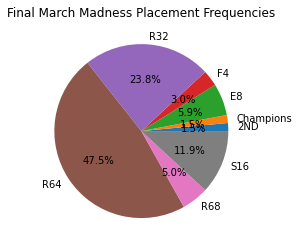

In [201]:
importlib.reload(mysklearn.myutils)
import matplotlib.pyplot as plt
import tabulate
placement_values, placement_freqs = myutils.get_frequencies(y_train_bball,['POSTSEASON'],'POSTSEASON')
plt.figure()
plt.pie(placement_freqs,labels=placement_values,autopct="%1.1f%%")
plt.title("Final March Madness Placement Frequencies")
plt.show()


#### Figure 2 and 3: Box and Whisker Plot of Attribute Distributions

We then can see the distribution of all of our attributes after normalization is pretty uniform which proves that this function does its job correctly. Prior to performing this function call, the attributes had a pretty high volatility and variance. The only category which did not get distirbuted great was the BARTHAG statistic, which is very highly concentrated on the high end of the scale. So, we may use a different method for normalizing this attribute. I captured this problem more specifically with figure 3. 

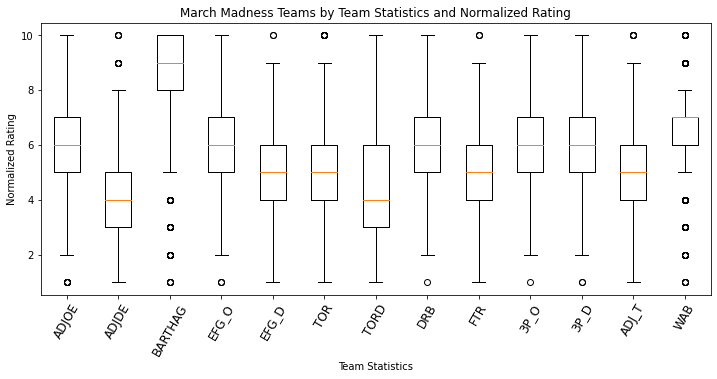

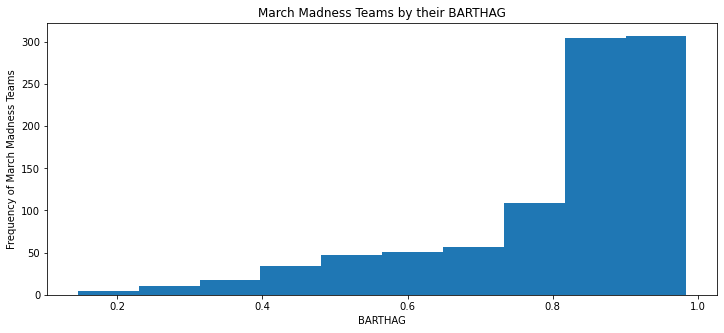

In [202]:
importlib.reload(mysklearn.myutils)
myutils.build_box_plot("March Madness Teams",'Team Statistics','Normalized Rating',stats_col[:-1],stats_header[:-1])
myutils.basic_histogram("March Madness Teams",'BARTHAG',myutils.get_column(bball_table.data,bball_table.column_names,'BARTHAG'))

### Figure 4 and 5: Relationships through Scatters

We looked at the relationship with a lot of the attributes individually in relation to the class level attribute of placement in the tournament and found that they all had a very similar output. So, here is that ouput for two of the attributes. So, we can see that these results trend clearly upward for better and better placed teams. But the correlations are not strong watsoever. This tells us that our predictive power with a lot of these variables will not be super strong. ADJOE is a teams adjusted offensive efficiency which takes into account a bunch of offensive factors and rate how a team performs overall. WAB is a teams wins above bubble which essentially ranks how a given team performs against the strength of the teams which they are playing.

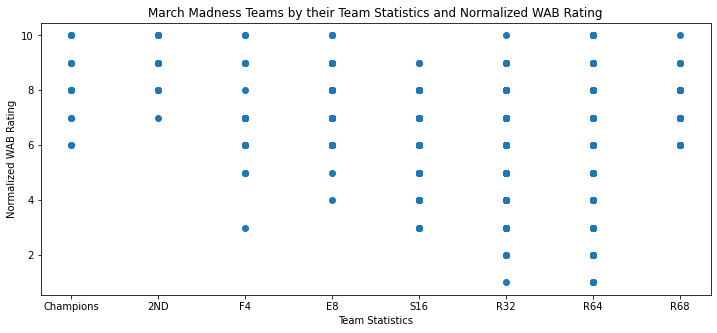

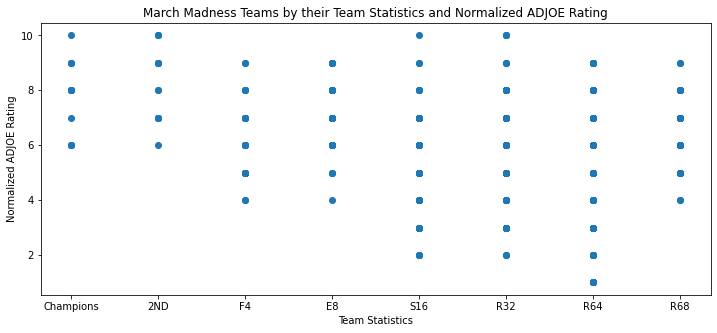

In [203]:
importlib.reload(mysklearn.myutils)
myutils.build_scatter("March Madness Teams",'Team Statistics','Normalized WAB Rating',
    myutils.discretize_rounds_to_nums(y_train_bball,unique_classes),
    myutils.get_column(X_train_bball,stats_header,'WAB'),labels=unique_classes)
myutils.build_scatter("March Madness Teams",'Team Statistics','Normalized ADJOE Rating',
    myutils.discretize_rounds_to_nums(y_train_bball,unique_classes),
    myutils.get_column(X_train_bball,stats_header,'ADJOE'),labels=unique_classes)

 #### Tables 1 and 2: Mean Distributions Grouped by Class
 We then created a large table of the means for each possible attribute grouped by the class label of teams final placement to see how the trends look. We can clearly see here that for pretty much all statistics, the average is increasing as the teams finishing position gets better and better. Of course the number of instance drops with each successive level as well. Most of the attributes do not have a lot of variation among each possible post season outcome, except for BARTHAG and WAB. These two statistics have very different results between each level of postseason outcome. So, it would be valuable to treat these two attributes with higher prominence. 

In [204]:
importlib.reload(mysklearn.myutils)
import matplotlib.pyplot as plt
import tabulate

class_groups = myutils.group_by(bball_table.data,bball_table.column_names,'POSTSEASON')
summary_statistics = []
for i, class_group in enumerate(class_groups[1]):
    summary_statistics.append({"postseason":class_groups[0][i],
                               "mean_adjoe":np.mean(myutils.get_column(class_group,bball_table.column_names,'ADJOE')),
                                "mean_adjde":np.mean(myutils.get_column(class_group,bball_table.column_names,'ADJDE')),
                                "mean_adjt":np.mean(myutils.get_column(class_group,bball_table.column_names,'ADJ_T')),
                                "mean_wab":np.mean(myutils.get_column(class_group,bball_table.column_names,'WAB')),
                                "mean_barthag":np.mean(myutils.get_column(class_group,bball_table.column_names,'BARTHAG')),
                                "mean_efg_o":np.mean(myutils.get_column(class_group,bball_table.column_names,'EFG_O')),
                                "mean_efg_d":np.mean(myutils.get_column(class_group,bball_table.column_names,'EFG_D')),
                                "mean_tor":np.mean(myutils.get_column(class_group,bball_table.column_names,'TOR'))})

header = summary_statistics[0].keys()
rows = [x.values() for x in summary_statistics]
print(tabulate.tabulate(rows, header))
print() 
summary_statistics = []
for i, class_group in enumerate(class_groups[1]):
    summary_statistics.append({"postseason":class_groups[0][i],
                                "mean_tord":np.mean(myutils.get_column(class_group,bball_table.column_names,'TORD')),
                                "mean_drb":np.mean(myutils.get_column(class_group,bball_table.column_names,'DRB')),
                                "mean_ftr":np.mean(myutils.get_column(class_group,bball_table.column_names,'FTR')),
                                "mean_ftrd":np.mean(myutils.get_column(class_group,bball_table.column_names,'FTRD')),
                                "mean_2p_o":np.mean(myutils.get_column(class_group,bball_table.column_names,'2P_O')),
                                "mean_2p_d":np.mean(myutils.get_column(class_group,bball_table.column_names,'2P_D')),
                                "mean_3p_o":np.mean(myutils.get_column(class_group,bball_table.column_names,'3P_O')),
                                "mean_3p_d":np.mean(myutils.get_column(class_group,bball_table.column_names,'3P_D'))})

header = summary_statistics[0].keys()
rows = [x.values() for x in summary_statistics]
print(tabulate.tabulate(rows, header))

postseason      mean_adjoe    mean_adjde    mean_adjt    mean_wab    mean_barthag    mean_efg_o    mean_efg_d    mean_tor
------------  ------------  ------------  -----------  ----------  --------------  ------------  ------------  ----------
2ND                117.264       90.6929      67.4786    6.65            0.942829       53.1429       46.1857     16.6571
Champions          121.171       90.2071      67.5714    8.91429         0.964179       53.8143       45.6929     16.7357
E8                 116.189       92.2714      67.5607    6.08393         0.92415        53.0286       46.4464     17.4661
F4                 116.164       91.5536      66.6821    6.14643         0.931257       52.1857       46.1857     17.6214
R32                112.068       94.321       67.1049    2.80402         0.864002       51.7647       47.1317     17.8366
R64                108.219       97.7321      67.3694   -0.690848        0.732608       51.567        47.8558     18.4453
R68                104.9

## Classification Results
Finally, we can run our dataset through our classifiers and do some learning!! Now, we are going to utilize our stratified k fold cross validation data evaluator function to create a bunch of different variations of our dataset to classify against. Then we are going to run all of our classifiers through it in order to have very comprehensive metrics. From these results we will know what our best classifier is for this particular dataset. 
Here are our classifiers:
1. Dummy Classifier: This classifier will take the most common class attribute and always predict it
1. KNN Classifier: This classifier finds the closest k neighbors of a given attribute and predicts from a majority vote of these corresponding class labels
1. Naive Bayes Classifier: This classifier uses complex probability measurements to find the highest probability class label based on all of the individual probabilities of the given attribute labels
1. Random Forest Classifier: This classifier initially breaks the dataset into a training and testing set. The training set is then used to create N "weak trees" where M "strong trees" are selected from these. 
    1. Our implementation uses both a random subset of attributes as well as using a random training and validation subset using the bootstrap method. Both of these factors will give us a lot of variety in our tree results
We will be calculating metrics for accuracy and error rate to figure out which will be the winner. 


In [206]:
importlib.reload(mysklearn.myutils)
importlib.reload(mysklearn.mypytable)
importlib.reload(mysklearn.myclassifiers)
importlib.reload(mysklearn.myevaluation)
from tabulate import tabulate
import numpy as np
np.random.seed(5)
K_VALUE = 7
print('===========================================')
print("Predictive Accuracy")
print('===========================================')
X_train_folds, X_test_folds = myeval.stratified_kfold_cross_validation(X_train_bball_origin,y_train_bball_origin,n_splits=K_VALUE,shuffle=True)
X_train_bball, X_test_bball = [], []
y_dummy_predictions_folds, y_knn_predictions_folds, y_nb_predictions_folds, y_tree_predictions_folds, y_forest_predictions_folds = [], [], [], [], []
y_actuals_folds = []
y_train_bball, y_test_bball = [], []
print('===========================================')
for i, X_train_fold in enumerate(X_train_folds):
    for instance_index in X_train_fold:
        X_train_bball.append(X_train_bball_origin[instance_index])
        y_train_bball.append(y_train_bball_origin[instance_index])
    for instance_index in X_test_folds[i]:
        X_test_bball.append(X_train_bball_origin[instance_index])
        y_test_bball.append(y_train_bball_origin[instance_index])
    knn_classifier = MyKNeighborsClassifier(K_VALUE)
    y_actuals_folds.append(y_test_bball)
    knn_classifier.fit(X_train_bball,y_train_bball)
    y_predictions = knn_classifier.predict(X_test_bball)
    y_knn_predictions_folds.append(y_predictions)
    dummy_classifier = MyDummyClassifier()
    dummy_classifier.fit(X_train_bball,y_train_bball)
    y_predictions = dummy_classifier.predict(X_test_bball)
    y_dummy_predictions_folds.append(y_predictions)
    nb_classifier = MyNaiveBayesClassifier()
    nb_classifier.fit(X_train_bball,y_train_bball)
    # TODO: fix the nb classifier to implement the predict method correctly here
    y_predictions = nb_classifier.predict(X_test_bball)
    y_nb_predictions_folds.append(y_predictions)
    tree_classifier = MyDecisionTreeClassifier()
    tree_classifier.fit(X_train_bball,y_train_bball)
    y_predictions = tree_classifier.predict(X_test_bball)
    y_tree_predictions_folds.append(y_predictions)
    X_train_bball, X_test_bball, y_train_bball, y_test_bball = [], [], [], []

# convert a nested list into a flat list
y_actuals_folds = [item for sublist in y_actuals_folds for item in sublist]
y_knn_predictions_folds = [item for sublist in y_knn_predictions_folds for item in sublist]
y_dummy_predictions_folds = [item for sublist in y_dummy_predictions_folds for item in sublist]
y_nb_predictions_folds = [item for sublist in y_nb_predictions_folds for item in sublist]
y_tree_predictions_folds = [item for sublist in y_tree_predictions_folds for item in sublist]
knn_accuracy = myeval.accuracy_score(y_actuals_folds,y_knn_predictions_folds,normalize=True)
dummy_accuracy = myeval.accuracy_score(y_actuals_folds,y_dummy_predictions_folds,normalize=True)
nb_accuracy = myeval.accuracy_score(y_actuals_folds,y_nb_predictions_folds,normalize=True)
tree_accuracy = myeval.accuracy_score(y_actuals_folds,y_tree_predictions_folds,normalize=True)

# Finally we are going to build the Random Forest which is implemented completely differently than any of our other models
forest_classifier = MyRandomForestClassifier()
forest_classifier.fit(X_train_bball_origin,y_train_bball_origin,100,9,8,random_state=5)
y_forest_predictions = forest_classifier.predict()
forest_accuracy = myeval.accuracy_score(forest_classifier.y_test,y_forest_predictions,normalize=True)

print("Stratified 10-Fold Cross Validation")
print("k Nearest Neighbors Classifier: ")
print("accuracy =",knn_accuracy,"error rate =",1 - knn_accuracy)
print("Dummy Classifier: ")
print("accuracy =",dummy_accuracy,"error rate = ",1 - dummy_accuracy)
print("Naive Bayes Classifier: ")
print("accuracy =",nb_accuracy,"error rate = ",1 - nb_accuracy)
print("Decision Tree Classifier: ")
print("accuracy =",tree_accuracy,"error rate = ",1 - tree_accuracy)
print("Random Forest Classifier: ")
print("accuracy =",forest_accuracy,"error rate = ",1 - forest_accuracy)
print("===========================================")


Predictive Accuracy


#### Classification Results

So, we can see here that the dummy classifier is going to takeover as one of our strongest classifiers 9 times out of 10. This is because of the heavy lob-sided nature of our class labels. Yet, we found that the Random Forest Classifier actually predicted more accurate results a majority of the time.

## Conclusions
Through this analysis of the March Madness Bracket we can say that our best classifier here will give us relatively good predictions if we were to deploy this to be used in the next bracket tournament. 

Yet, overall I think we were somewhat disappointed with our results. We were glad that we scored above the dummy classifier on average, but we still wanted to get results closer to 70% at least. Of course the march madness tournament is one of the most difficult things to predict, but we still think we could have gotten higher predictive accuracy with some better attributes.

Specifically, we think that we could have calculated in the matchups in a given tournament bracket, but this would have just taken a lot of time to implement. I think we could have had much more accurate results though if we utilized what teams would potentially matchup as well as records against these given teams. In order to deploy this code anyways, we would be required to make predictions that fit into the bracket format which ours is not doing. So, this method could help solve that problem. 

We also could have achieved better results by having a more balanced distribution of the class labels. This would have brought the dummy classifiers scores down by a lot and increased our other classifiers which were more inclined to pick the class of "Champions". 

Finally, we did not really perform classification metric equivalently for all of our classifiers because the Random Forest Classifier was structured in a very different way than any of the other classifiers. So, I think we would have gotten more accurate and reliable results if we had structured them all in the same way.

##